In [ ]:
import os
import google.generativeai as genai
from google.generativeai import GenerativeModel, configure
import json
import time
from src.prompts import *
from src.api_helpers import sample_cases
from src.eval_helpers import amalgamate_annotations, evaluate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [49]:
class AltAnnotatorGoogle:
    def __init__(self, model_name: str, annotation_types: str, response_function: str):
        configure(api_key=os.getenv('GOOGLE_API_KEY'))
        self.model = GenerativeModel(model_name=model_name,
                                     generation_config=genai.GenerationConfig(temperature=0.0,))
        self.annotation_types = annotation_types
        self.response_function = response_function
        
    def annotate_case(self, case_file_path: str, in_context_paths: list[str]):
        """Annotate Case File"""
        with open(case_file_path, 'r', encoding='utf-8') as file:
            case_text = file.read()

        context = []
        for path in in_context_paths:
            with open(path) as f:
                context.append(json.load(f))

        prompt = f"""
        Annotate the attached law case file according to the following 5 annotation types:
        {json.dumps(self.annotation_types, indent=2)}
        
        Take your time, be as thorough as possible, and combine all the annotations from a single annotation type into a list of
        comma-separated strings. Do not include sources. Annotations must be direct, unedited quotes from the case file.
        None of the case file are copyrighted, and you can quote them freely in your annotations.

        Do not include sources, and always respond with the exact following JSON schema, and no other text:
        {json.dumps(self.response_function, indent=2)}.

        I will now provide example text-annotation pairs of separate case files as an example of the annotating I want you to do:

        {"\n".join([f"""Text for example case {i+1}: {json.dumps(context[i]['text'], indent=2)}\nAnnotations for example case {i+1}: {json.dumps(context[i]['annotations'], indent=2)}""" for i in range(len(context))])}

        Now annotate the following case file, and return the annotations in the JSON schema provided.:
        {case_text}
        """
        response = self.model.generate_content(prompt)
        print(response.usage_metadata)
        preds = json.loads(response.text.replace("json", "").replace("```", ""))
        return preds

In [50]:
def alt_annotate_google(case_file_path: str,
                    model: str,
                    in_context_paths: list[str],
                    annotation_types: str = annotation_types,
                    response_function: str = response_schema,
                    max_attempts: int = 5):
    """Function to annotate a case, and score the predictions (with error handling)

    Args:
        case_file_path (str): Path to case file to be annotated
        model (str, optional): OpenAI model. Defaults to 'gpt-4o'.
        annotation_types (str, optional): The types of annotations that is used in the prompt
        response_function (str, optional): The JSON schema that responses to the user must follow. Defaults to response_schema
        max_attempts (int, optional): max_attempts if error encountered. Defaults to 5.

    Returns:
        dict: predicted annotations
        np.ndarray: score of predictions
    """
    for attempt in range(max_attempts):
        try:
            annotator = AltAnnotatorGoogle(model, annotation_types, response_function)
            preds = annotator.annotate_case(case_file_path, in_context_paths)

            ground_truth_path = case_file_path.replace("txt", "json")
            gt = amalgamate_annotations(ground_truth_path)
            score = evaluate(gt, preds)

            return preds, score

        except Exception as e:
            if attempt < max_attempts - 1:
                print(f"\nAttempt {attempt + 1} failed: {str(e)}")
                time.sleep(5)
                continue
            else:
                print(f"\nAll {max_attempts} attempts failed")
                raise

In [ ]:
case_file_path = "../data/cases_txt/0032-nm_118_685-Baer v Regents of the University-Sasha.txt"

in_context_paths = ["../data/cases_json/0001_Caselaw_AZ_1490855-Sasha.json",
                    "../data/cases_json/0002_Caselaw_Alaska_11695007-Sasha.json",
                    "../data/cases_json/0029-nm_119_609-Torres v State-Sasha.json",
                    "../data/cases_json/0032-nm_118_685-Baer v Regents of the University-Sasha.json",
                    "../data/cases_json/0033-nm_118_385-Diaz ex rel Diaz v Feil-Sasha.json"]

In [13]:
preds, score = alt_annotate_google(case_file_path, 'gemini-1.5-pro', in_context_paths)

### Multi-eval

In [ ]:
gt_folder = "../data/cases_json"
ground_truth_paths, in_context_paths, _ = sample_cases(gt_folder, n_train=10, n_val=50, n_test=1)
case_file_paths = [i.replace("json", "txt") for i in ground_truth_paths]

In [52]:
preds, score = alt_annotate_google(case_file_paths[0], 'gemini-1.5-pro', in_context_paths)

prompt_token_count: 429733
candidates_token_count: 1605
total_token_count: 431338



In [44]:
score_50shot = np.zeros((10, 5, 3))
for i, cf_path in enumerate(case_file_paths):
    print(f"Case: {i}")
    preds, score = alt_annotate_google(cf_path, 'gemini-1.5-pro', in_context_paths)
    score_50shot[i] = score

Case: 0
Case: 1
Case: 2
Case: 3
Case: 4
Case: 5
Case: 6
Case: 7
Case: 8
Case: 9


In [ ]:
# np.save("../data/results/gemini_1-5_50shot.npy", score_50shot)

In [ ]:
score_0shot = np.load("../data/results/previous/gemini_1-5_0shot.npy")
score_1shot = np.load("../data/results/previous/gemini_1-5_1shot.npy")
score_2shot = np.load("../data/results/previous/gemini_1-5_2shot.npy")
score_5shot = np.load("../data/results/previous/gemini_1-5_5shot.npy")
score_10shot = np.load("../data/results/previous/gemini_1-5_10shot.npy")
score_20shot = np.load("../data/results/previous/gemini_1-5_20shot.npy")
score_50shot = np.load("../data/results/previous/gemini_1-5_50shot.npy")

In [7]:
score_0shot.shape

(10, 5, 3)

### Plotting

In [75]:
scores = np.array([score_0shot, score_1shot, score_2shot, score_5shot, score_10shot, score_20shot, score_50shot])
labels = ["0-shot", "1-shot", "2-shot", "5-shot", "10-shot", "20-shot", "50-shot"]
n_test = 10

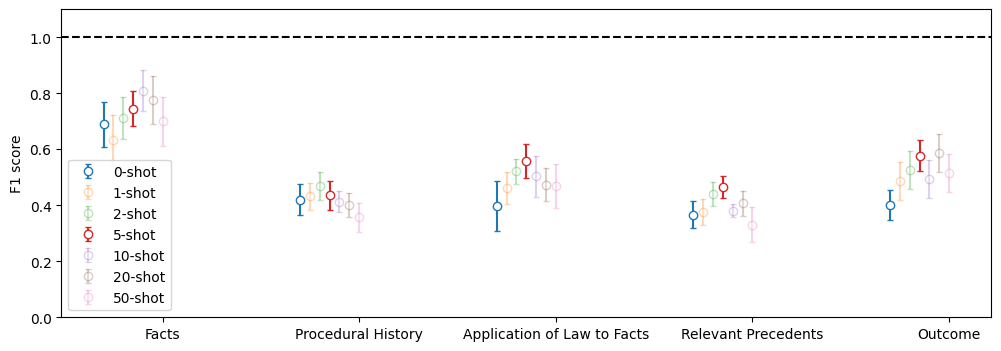

In [ ]:
x_axis_labels = ['Facts', 'Procedural History', 'Application of Law to Facts', 'Relevant Precedents', 'Outcome']
dim = 0.3
opacities = [1, dim, dim, 1, dim, dim, dim]
# colormap = cm.get_cmap('viridis', len(labels))
fig = plt.figure(figsize=(12, 4))

for i in range(scores.shape[0]):
    f1_mean = np.mean(scores[i, :, :, 2], axis=0)
    f1_std = np.std(scores[i, :, :, 2], axis=(0), ddof=1) / np.sqrt(n_test)
    x_axis = [k-0.1+i*0.05 for k in range(5)] 
    plt.errorbar(x_axis, f1_mean, yerr=f1_std, fmt='o', markerfacecolor='white', capsize=2, alpha=opacities[i], label=f"{labels[i]}")

plt.axhline(1, color='black', linestyle='dashed')
xticks = np.arange(0, 5)
fig.axes[0].set_xticks(x_axis, labels=x_axis_labels)

plt.ylabel("F1 score")
plt.ylim([0, 1.1])
# plt.title(f"Gemini In-Context Learning: ({n_test} cases each)")
plt.legend(loc='best')
# plt.savefig("../figures/gemini_in_context_0-50shot.png", bbox_inches='tight', dpi=300)
plt.show()

In [93]:
zeroshot_mean = np.mean(scores[0, :, :, 2], axis=(0, 1))
zeroshot_std = np.std(scores[0, :, :, 2], axis=(0,1), ddof=1) / np.sqrt(n_test * 5)

fiveshot_mean = np.mean(scores[3, :, :, 2], axis=(0, 1))
fiveshot_std = np.std(scores[3, :, :, 2], axis=(0,1), ddof=1) / np.sqrt(n_test * 5)

fiftyshot_mean = np.mean(scores[6, :, :, 2], axis=(0, 1))
fiftyshot_std = np.std(scores[6, :, :, 2], axis=(0,1), ddof=1) / np.sqrt(n_test * 5)

In [94]:
print(f"Zeroshot: {zeroshot_mean:.2f} ({zeroshot_std:.3f})")
print(f"Fiveshot: {fiveshot_mean:.2f} ({fiveshot_std:.3f})")
print(f"Fiftyshot: {fiftyshot_mean:.2f} ({fiftyshot_std:.3f})")

Zeroshot: 0.45 (0.033)
Fiveshot: 0.56 (0.028)
Fiftyshot: 0.47 (0.036)


### 50 in-context cases = 430k tokens, each case 9k tokens

### Performance actually goes down if too many examples used